# GGA 的 Kohn-Sham 交换相关势函数导出

这篇文档将会以 PBE 为例，求取 (pure，不包含 exact exchange 部分) 闭壳层 (Restricted) GGA (Generalized Gradient Approximation) 的交换相关势函数 $v_\mathrm{xc} (\boldsymbol{r})$。这篇文档的一些记号会倾向于 [pyxdh 文档](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga.html)，但所有与泛函核或其导数有关的量，不乘以格点权重。

In [1]:
%matplotlib notebook
from pyscf import gto, dft
import numpy as np
from functools import partial
from matplotlib import pyplot as plt

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 4 / 8])
np.set_printoptions(5, linewidth=150, suppress=True)

## Slater 交换势函数导出

在讨论 GGA 的交换相关势前，我们讨论一下比较简单的情形，即 LDA (Local Density Approximation) 的 Slater 泛函。

我们知道，对于最为简单的交换相关泛函，Slater 泛函 (尽管它不包含相关部分，但从实现角度上讲是类似的)，其泛函的形式为 (参考 [Wikipedia 页面](https://en.wikipedia.org/wiki/Local-density_approximation#Exchange_functional))

$$
E_\mathrm{x}^{\mathsf{Slater}}[\rho] = - \frac{3}{4}\left( \frac{3}{\pi} \right)^{1/3} \int\rho(\boldsymbol{r})^{4/3} \, \mathrm{d} \boldsymbol{r}
$$

因此，其交换势则可以推导得到

$$
v_\mathrm{x}^\mathsf{Slater} (\boldsymbol{r}) = \frac{\delta \, E_\mathrm{x}^{\mathsf{Slater}}[\rho]}{\delta \, \rho(\boldsymbol{r})} = - \left( \frac{3}{\pi} \right)^{1/3} \rho(\boldsymbol{r})^{1/3}
$$

但 Slater 泛函是一种 LDA (Local Density Approximation)，其交换相关 (尽管没有相关部分) 势可以很容易地直接通过泛函的变分获得；从程序上来讲，在我所习惯的记号下，也可以容易地从 (不加权重的) $f_{\rho}$ 得到。我们以 Ne 原子与 6-311G 基组为例，以 Slater 泛函下的自洽场密度，绘制其径向格点：

In [2]:
ni = dft.numint.NumInt()

In [3]:
mol = gto.Mole()
mol.atom = """Ne"""
mol.basis = "6-311G"
mol.verbose = 0
mol.build()

In [4]:
grids = dft.Grids(mol).build()

In [5]:
mf = dft.RKS(mol)
mf.xc = "Slater"
mf.grids = grids
mf.run()

- `rad_ngrid`：径向格点数量，用于作图

- `rad_x`：径向格点的 $x$ 坐标分量 (格点到原子核间距离)，生成方式为从 $10^{-3}$ 到 $10^{1}$ 的长度为 1000 的等比数列

- `rad_coord`：径向格点的三维坐标

In [6]:
rad_ngrid = 1000
rad_x = np.logspace(-3, 1, rad_ngrid)
rad_coord = np.array([rad_x, np.zeros(rad_ngrid), np.zeros(rad_ngrid)]).T

- `rad_occ_0` $\phi_i (\boldsymbol{r}_g)$ 分子轨道 $i$ 函数在格点上的数值，通过 $\phi_i = \sum_\mu \phi_\mu C_{\mu i}$ 得到

- `rad_rho_0` $\rho (\boldsymbol{r}_g)$，但该密度只表示在径向 $\boldsymbol{r}_g = (x_g, 0, 0)$ 上的格点，与 `rho_0` 尽管物理意义相同，但后者的格点是全空间的，可以被积分的格点

In [7]:
rad_ao_0 = ni.eval_ao(mol, rad_coord, deriv=0)
rad_rho_0 = ni.eval_rho(mol, rad_ao_0, mf.make_rdm1())

`rad_xc` 表示从 PySCF 的程序得到的 $f_\mathrm{\rho}$，其定义为

$$
f_{\rho} = \frac{\partial (f[\rho] \rho)}{\partial \rho}
$$

上式中的 $f[\rho]$ 表示的是泛函核，其定义可以从下式看出

$$
E_\mathrm{xc} [\rho] = \int f[\rho] \rho(\boldsymbol{r}) \, \mathrm{d} \boldsymbol{r}
$$

因此，对于 LDA 而言，

$$
f_{\rho} (\boldsymbol{r}) = \frac{\delta \, E_\mathrm{xc} [\rho]}{\delta \, \rho (\boldsymbol{r})} = v_\mathrm{xc} (\boldsymbol{r})
$$

上述记号有时会引起混淆，譬如说 $f_{\rho}$ 可以作为关于 $\boldsymbol{r}$ 的函数，此时的意义就与交换相关势函数 $v_\mathrm{xc} (\boldsymbol{r})$ 一致；也可以作为关于 $\rho$ 的泛函，因为对于不同的密度而言，$f_{\rho}$ 并不相同；以及在程序中，$f_{\rho}$ 是一种格点，因此它可能还用于求取格点积分。有时，我们也会将泛函核 $f[\rho]$ 简写成 $f$。这些不同的符号会在不同语境下，起到不同作用；读者或许需要对这些问题留个心眼。当然，程序的结果是确实的、能用于验证的。

我们再用 `rad_xc_anal_expression`，拿 Slater 交换相关势的精确表达式，来用于验证我们通过 PySCF 程序所给出的交换相关势确实是正确的：

In [8]:
rad_xc = ni.eval_xc("Slater", rad_rho_0, deriv=1)[1][0]
rad_xc_anal_expression = - (3 / np.pi)**(1 / 3) * rad_rho_0**(1 / 3) 

下面我们就可以绘制 Slater 交换相关势了。图中所述的复现图片，是指 [JCTC, 2013, 9, 3959-3964](https://dx.doi.org/10.1021/ct4004146) 的文章。

<IPython.core.display.Javascript object>


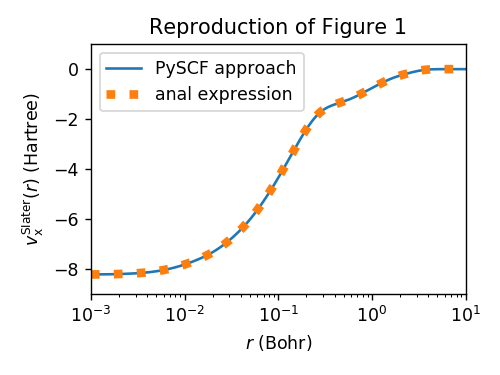

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(rad_x, rad_xc, label="PySCF approach")
ax.plot(rad_x, rad_xc_anal_expression, linestyle=":", linewidth=5, label="anal expression")
ax.set_xscale("log"), ax.legend(loc="upper left")
ax.set_xlim(1e-3, 1e1), ax.set_ylim(-9, 1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{x}^\mathsf{Slater} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 1")
fig.tight_layout()

## PBE 交换相关势的导出

### 交换相关势矩阵的验证

但相同的做法不能在 PBE 泛函 (或者一般地，pure GGA 泛函) 中使用。对于量化中所会使用到的 $v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | \hat v_\mathrm{xc} | \nu \rangle$ 交换相关势矩阵，我们曾经在 [pyxdh 文档](https://py-xdh.readthedocs.io/zh_CN/latest/qcbasic/basic_gga.html#%E4%BB%BB%E5%8A%A1-(3.3)-%E5%8F%AF%E9%80%89) 的任务 (3.3) 中 作过较为细致的推导，这里给出其表达式：

$$
\begin{align}
v_{\mu \nu}^\mathrm{xc} [\rho] &= \sum_r \int \big[ f_\rho \phi_\mu \phi_\nu + 2 f_\gamma \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \big] \, \mathrm{d} \boldsymbol{r} \\
&= \langle \mu | f_\rho | \nu \rangle + 2 \sum_r \langle \mu_r | f_\gamma \rho_r | \nu \rangle + 2 \sum_r \langle \mu | f_\gamma \rho_r | \nu_r \rangle
\end{align}
$$

其中，上式的

$$
\begin{align}
f_\gamma = \frac{\partial (f \rho)}{\partial \gamma}, \quad \rho_r = \frac{\partial \rho}{\partial r}, \quad \mu_r = \frac{\partial \mu}{\partial r}
\end{align}
$$

上式中的斜体 (而非粗斜体) $r$ 或之后会出现的 $w$ 代表三维电子坐标 $\boldsymbol{r}$ 的一个坐标分量。如果用较为普通的写法的话，则有

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle
$$

上式的两个 $\nabla$ 梯度记号都使用点乘内积作计算。我们不妨先用程序验证一下上式的正确性。我们首先重新用 PBE 泛函计算一遍自洽场过程：

In [10]:
mf = dft.RKS(mol)
mf.xc = "PBE"
mf.grids = grids
mf.run()

- `C` $C_{\mu p}$ 分子轨道系数矩阵

- `D` $D_{\mu \nu}$ 电子态密度矩阵

In [11]:
C = mf.mo_coeff
D = mf.make_rdm1()

- `ao_0` $\phi_\mu$, `ao_1` $\phi_{r \mu} = \partial_r \phi_\mu$, `ao_2` $\phi_{rw \mu} = \partial_r \partial_w \phi_\mu$ 为原子轨道函数格点与其导数

In [12]:
ao = ni.eval_ao(mol, grids.coords, deriv=2)
ao_0, ao_1 = ao[0], ao[1:4]
ao_2 = np.array([
    [ao[4], ao[5], ao[6]],
    [ao[5], ao[7], ao[8]],
    [ao[6], ao[8], ao[9]],
])

- `rho_0` $\rho$, `rho_1` $\rho_r = \partial_r \rho$, `rho_2` $\rho_{rw} = \partial_r \partial_w \rho$ 为电子态密度格点

In [13]:
rho_0 = np.einsum("gu, gv, uv -> g", ao_0, ao_0, D)
rho_1 = 2 * np.einsum("rgu, gv, uv -> rg", ao_1, ao_0, D)
rho_2 = (
    + 2 * np.einsum("rwgu, gv, uv -> rwg", ao_2, ao_0, D)
    + 2 * np.einsum("rgu, wgv, uv -> rwg", ao_1, ao_1, D)
)

- `gamma_0` $\gamma = \nabla \rho \cdot \nabla \rho$, `gamma_1` $\gamma_r = \partial_r \gamma$

In [14]:
gamma_0 = np.einsum("rg, rg -> g", rho_1, rho_1)
gamma_1 =  2 * np.einsum("rwg, wg -> rg", rho_2, rho_1)

- `fr` $f_\rho$, `fg` $f_\gamma$, `frr` $f_{\rho \rho}$, `frg` $f_{\rho \gamma}$, `fgg` $f_{\gamma \gamma}$ 表示对泛函核与密度乘积 $f \rho$ 的求导，下角标表示被求导对象

In [15]:
_, vxc, fxc, _ = ni.eval_xc("PBE, PBE", np.concatenate([rho_0[None, :], rho_1]), deriv=2)
fr, fg = vxc[:2]
frr, frg, fgg = fxc[:3]

那么，交换相关矩阵 $v_{\mu \nu}^\mathrm{xc}$ 可以用 `Vxc` 表述：

In [16]:
Vxc = (
    + np.einsum("g, g, gu, gv -> uv", grids.weights, fr, ao_0, ao_0)
    + 2 * np.einsum("g, g, rg, rgu, gv -> uv", grids.weights, fg, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, g, rg, gu, rgv -> uv", grids.weights, fg, rho_1, ao_0, ao_1)
)

验证 `Vxc` $v_{\mu \nu}^\mathrm{xc}$ 的方法，可以是生成分子轨道下的 Fock 矩阵。我们知道，Canonical RKS 的 Fock 矩阵是对角化的，我们就用这样一个性质来验证：

In [17]:
F = (
    + np.einsum("uv, up, vq -> pq", mol.intor("int1e_kin"), C, C)
    + np.einsum("uv, up, vq -> pq", mol.intor("int1e_nuc"), C, C)
    + np.einsum("uvkl, kl, up, vq -> pq", mol.intor("int2e"), D, C, C)
    + np.einsum("uv, up, vq -> pq", Vxc, C, C)
)

出于文档美观考虑，我们只显示出占据轨道部分的 Fock 矩阵；读者若自己执行代码，不难验证其余部分也遵循对角化矩阵。

In [18]:
F[:5, :5]

array([[-30.44674,  -0.     ,   0.     ,   0.     ,   0.     ],
       [ -0.     ,  -1.30498,  -0.     ,  -0.     ,  -0.     ],
       [  0.     ,  -0.     ,  -0.46122,  -0.     ,   0.     ],
       [  0.     ,  -0.     ,  -0.     ,  -0.46122,   0.     ],
       [ -0.     ,  -0.     ,  -0.     ,   0.     ,  -0.46122]])

### 交换相关势作为径向函数的导出

我们再回顾一下交换相关势的计算：

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle
$$

但从上式，从上式我们或许可以不严谨地写

$$
\hat v_\mathrm{xc} = f_\rho + 2 f_\gamma \nabla \rho \cdot \nabla + 2 \nabla {\square} \cdot f_\gamma \nabla \rho
$$

但我们其实不能直接地从上述表达式获得 $v_\mathrm{xc} (\boldsymbol{r})$ 的信息。为此，我们需要将上式重新整理为

$$
v_{\mu \nu}^\mathrm{xc} [\rho] = \langle \mu | f_\rho | \nu \rangle + 2 \langle f_\gamma \nabla \rho | \nabla (\mu \nu) \rangle
$$

对于上式等式右的第二项，我们可以通过 Gauss 定理 (类似于分部积分) 以及波函数本身无穷远处的性质，转化为

$$
\begin{align}
2 \langle f_\gamma \nabla \rho | \nabla (\mu \nu) \rangle &= 2 \int f_\gamma \nabla \rho \cdot \nabla (\phi_\mu \phi_\nu) \, \mathrm{d} \boldsymbol{r} \\
&= 2 \int_{\Sigma} \nabla \cdot (\phi_\mu \phi_\nu f_\gamma \nabla \rho) \, \mathrm{d} \boldsymbol{\Sigma} - 2 \int \phi_\mu \phi_\nu \nabla \cdot (f_\gamma \nabla \rho) \, \mathrm{d} \boldsymbol{r} \\
&= 0 - 2 \int \phi_\mu \phi_\nu \big[ f_{\rho \gamma} \nabla \rho \cdot \nabla \rho + f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho + f_\gamma \nabla^2 \rho \big] \, \mathrm{d} \boldsymbol{r}
\end{align}
$$

上式中，$\Sigma$ 所指代的曲面是一个延伸至无穷远的单连通曲面。根据波函数的特性，包含 $\mathrm{d} \boldsymbol{\Sigma}$ 的第二类曲面积分值为零。

我们可以利用上式的结论，生成 `Vxc_`，并与 `Vxc` 作验证，检查是否正确：

In [19]:
Vxc_ = (
    + np.einsum("g, gu, gv, g -> uv", grids.weights, ao_0, ao_0, fr)
    - 2 * np.einsum("g, gu, gv, g, rg, rg -> uv", grids.weights, ao_0, ao_0, frg, rho_1, rho_1)
    - 2 * np.einsum("g, gu, gv, g, rg, rg -> uv", grids.weights, ao_0, ao_0, fgg, gamma_1, rho_1)
    - 2 * np.einsum("g, gu, gv, g, gr -> uv", grids.weights, ao_0, ao_0, fg, rho_2.diagonal())
)

In [20]:
np.allclose(Vxc, Vxc_)

True

因此，上述的推导与程序印证就成立了。我们可以写

$$
\begin{align}
v_{\mu \nu}^\mathrm{xc} [\rho] &= \langle \mu | f_\rho | \nu \rangle + 2 \langle \nabla \mu | f_\gamma \nabla \rho | \nu \rangle + 2 \langle \mu | f_\gamma \nabla \rho | \nabla \nu \rangle \\
&= \langle \mu | f_\rho - 2 f_{\rho \gamma} \nabla \rho \cdot \nabla \rho - 2 f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho - 2 f_\gamma \nabla^2 \rho | \nu \rangle
\end{align}
$$

因此，现在才能自然地写到，交换相关势作为关于电子坐标的函数，可以写为

$$
\hat v_\mathrm{xc} = v_\mathrm{xc} (\boldsymbol{r}) = f_\rho - 2 f_{\rho \gamma} \nabla \rho \cdot \nabla \rho - 2 f_{\gamma \gamma} \nabla \gamma \cdot \nabla \rho - 2 f_\gamma \nabla^2 \rho
$$

需要注意到，这是对于 GGA 的情况。对于 LDA (就像一开始讨论的 Slater 泛函)，由于 $f \rho$ 并非是关于 $\gamma = \nabla \rho \cdot \nabla \rho$ 的泛函，因此自然地会退化为 $v_\mathrm{xc}^\mathsf{GGA} (\boldsymbol{r}) = f_\rho$。

### Ne 原子 6-311G 基组下的 PBE 交换相关势：图像绘制

既然我们上面已经验证过交换相关势求取的正确性与可行性，下面我们就不妨对距离 Ne 原子 $10^{-2}$ 到 $10^{1}$ Bohr 处的交换相关势作直接的绘图。下面的代码不再多作说明，其意义相信上文已经有足够多的描述了。

In [21]:
rad_ao = ni.eval_ao(mol, rad_coord, deriv=2)
rad_ao_0, rad_ao_1 = rad_ao[0], rad_ao[1:4]
rad_ao_2 = np.array([
    [rad_ao[4], rad_ao[5], rad_ao[6]],
    [rad_ao[5], rad_ao[7], rad_ao[8]],
    [rad_ao[6], rad_ao[8], rad_ao[9]],
])

In [22]:
rad_rho_0 = np.einsum("gu, gv, uv -> g", rad_ao_0, rad_ao_0, D)
rad_rho_1 = 2 * np.einsum("rgu, gv, uv -> rg", rad_ao_1, rad_ao_0, D)
rad_rho_2 = (
    + 2 * np.einsum("rwgu, gv, uv -> rwg", rad_ao_2, rad_ao_0, D)
    + 2 * np.einsum("rgu, wgv, uv -> rwg", rad_ao_1, rad_ao_1, D)
)

In [23]:
rad_gamma_0 = np.einsum("rg, rg -> g", rad_rho_1, rad_rho_1)
rad_gamma_1 =  2 * np.einsum("rwg, wg -> rg", rad_rho_2, rad_rho_1)

In [24]:
_, rad_vxc, rad_fxc, _ = ni.eval_xc("PBE, PBE", np.concatenate([rad_rho_0[None, :], rad_rho_1]), deriv=2)
rad_fr, rad_fg = rad_vxc[:2]
rad_frr, rad_frg, rad_fgg = rad_fxc[:3]

In [25]:
rad_xc = (
    + rad_fr
    - 2 * np.einsum("g, rg, rg -> g", rad_frg, rad_rho_1, rad_rho_1)
    - 2 * np.einsum("g, rg, rg -> g", rad_fgg, rad_gamma_1, rad_rho_1)
    - 2 * np.einsum("g, gr -> g", rad_fg, rad_rho_2.diagonal())
)

In [26]:
rad_xc.shape

(1000,)

最后，我们就可以对其进行绘制。图中所述的复现图片，是指 [JCTC, 2013, 9, 3959-3964](https://dx.doi.org/10.1021/ct4004146) 的文章。

<IPython.core.display.Javascript object>


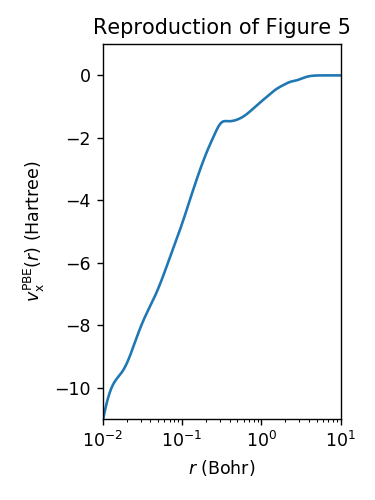

In [27]:
fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(rad_x, rad_xc)
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e1), ax.set_ylim(-11, 1)
ax.set_xlabel(r"$r$ (Bohr)")
ax.set_ylabel(r"$v_\mathrm{x}^\mathsf{PBE} (r)$ (Hartree)")
ax.set_title("Reproduction of Figure 5")
fig.tight_layout()